### Example notebook to analyze remote data on Zeus - C-GLORSv7

#### Prerequisite: prepare the environment 

1. Connect to the Zeus VPN using the VPN client, e.g. TunnelBlick

2. Add your local public key in the .ssh/authorized_keys on your Zeus account

3. Create the full conda environment starting from the requirements listed in *environment.yml* by running the following commands:

`conda env create -f environment.yml`

`source activate zapata`

Import Python utilities and setup Zeus username (replace YOURUSERNAME with your account)

In [14]:
import os, sys
sys.path.append("../")
import zeus
zeus.init(user="tl28319",host='zeus', remote_env='zapata')

zapata                   /users_home/oda/tl28319/.conda/envs/zapata


Start a Dask client on Zeus with 1 worker node (*n_workers = 1*)

In [15]:
from distributed import Client, get_client
client = zeus.start_dask(name="Zapata",
              project="R000",
              cores=36,
              processes=12,
              memory="80 GB",
              interface="ib0",
              walltime="00:30", 
              job_extra=["-x"], 
              n_workers=1
             )

/users_home/oda/tl28319/dask-space/connection
Scheduler address is: tcp://192.168.118.12:40281
Job <340759> is submitted to queue <p_short>.



Check if the cluster has been allocated on LSF (some time is required before LSF provides the resources; try to run the cell again after a few seconds). When available click on the **Dashboard** link to open the Dask monitoring interface.

In [16]:
client

Client Scheduler: tcp://192.168.118.12:40281 Dashboard: http://192.168.118.12:36533/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Let's load the C-GLORSv7 dataset using zapata data interface.

In [23]:
def read_remote():
    import sys
    sys.path.append('/users_home/oda/tl28319/GIT/Zapata')                       
    import zapata.data as zdat
    client = get_client()
    thedata = zdat.read_data(dataset='C-GLORSv7', var='votemper', period=[2000, 2000], season='JFM', level=[500.])
    return thedata

future = client.submit(read_remote)
temp = future.result()

Show the computation result

In [24]:
print(temp)
print("Size in bytes is : %i" % temp.nbytes)

<xarray.DataArray (time: 1, lev: 1, lat: 1050, lon: 1442)>
dask.array<getitem, shape=(1, 1, 1050, 1442), dtype=float64, chunksize=(1, 1, 1050, 1442), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-03-31
  * lev      (lev) float64 508.6
    nav_lon  (lat, lon) float32 72.75 73.0 73.25 ... 73.00568 73.000015 73.0
    nav_lat  (lat, lon) float32 -78.543434 -78.543434 ... 49.995502 49.995502
Dimensions without coordinates: lat, lon
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  1080 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 1080 s)
    coordinates:         time_centered deptht gphit glamt
    realm:               ocn
    time_resample:       JFM
Size in bytes is : 12112800


Create a map of the average temperature using zapata mapping tools.

In [26]:
import zapata.mapping as zmap

 Opening figure , 1 rows and 1 cols 



KilledWorker: ("('open_dataset-where-where-f413aefcefa7f62a67b4975cdad94bd2', 0, 0, 0, 0)", <Worker 'tcp://172.25.2.222:43040', name: 0-11, memory: 0, processing: 1>)

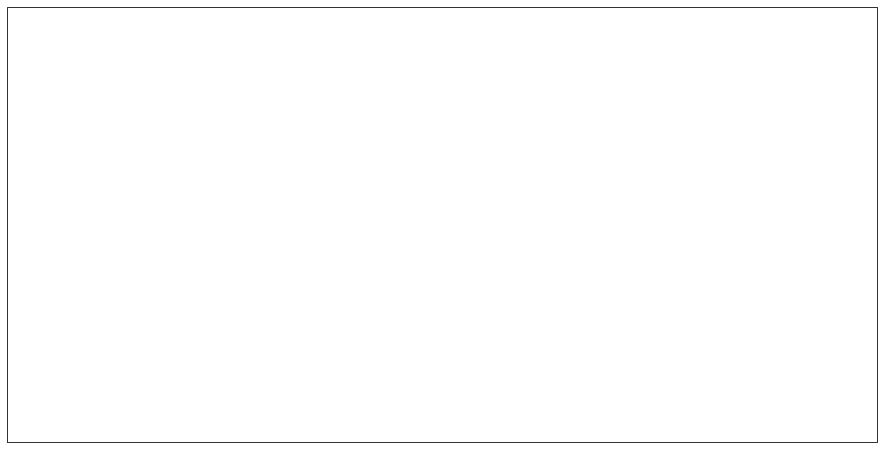

In [27]:
fig, ax, pro = zmap.init_figure(1, 1, 'Pacific', constrained_layout=False)
handle = zmap.xmap(temp, [], pro, ax=ax, maintitle='C-GLORSv7', lefttitle='SST', righttitle='JFM', cmap='coolwarm')
plt.savefig('test.png')

Shutdown the cluster and release the resources on LSF. Note sometimes warnings might be raised by the function due to synchronization effects.

In [25]:
zeus.stop_dask(client)